In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
from mint_general_interpolation_grid_builder.functions_natalie.custom_mpl_settings import (
    load_mpl_rc,
)
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()

from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.MS_table_builder import MainSequenceTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.CHeB_table_builder import (
    CoreHeliumBurningTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.EAGB_table_builder import (
    EarlyAsymptoticGiantBranchTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns


evol_phase = 'GB'

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/{evol_phase}',
    'metallicity':0.02,
    'num_processes':4
}

if evol_phase == 'MS':
    tester = MainSequenceTableBuilder(settings=settings)
elif evol_phase == 'GB':
    tester = RedGiantBranchTableBuilder(settings=settings)
elif evol_phase == 'CHeB':
    tester = CoreHeliumBurningTableBuilder(settings=settings)
elif evol_phase == 'EAGB':
    tester = EarlyAsymptoticGiantBranchTableBuilder(settings=settings)

Building a grid with (X_0, Y_0, Z_0)=(0.7, 0.28, 0.02)


Starting GB: MASS: 2.03, CENTRAL_DEGENERACY: -2.06, HELIUM_CORE_MASS_FRACTION: 0.0653
Finished GB: MASS: 2.03, CENTRAL_DEGENERACY: 19.77722251370368, HELIUM_CORE_MASS_FRACTION: 0.2517576929577907
Starting GB: MASS: 2.03, CENTRAL_DEGENERACY: -2.06, HELIUM_CORE_MASS_FRACTION: 0.0653
Finished GB: MASS: 2.03, CENTRAL_DEGENERACY: 16.69095430014497, HELIUM_CORE_MASS_FRACTION: 0.21144785329586765
Starting GB: MASS: 2.03, CENTRAL_DEGENERACY: -2.06, HELIUM_CORE_MASS_FRACTION: 0.0653
Finished GB: MASS: 2.03, CENTRAL_DEGENERACY: 16.595143127132392, HELIUM_CORE_MASS_FRACTION: 0.21177405540099872
Starting GB: MASS: 2.03, CENTRAL_DEGENERACY: -2.06, HELIUM_CORE_MASS_FRACTION: 0.0653
Finished GB: MASS: 2.03, CENTRAL_DEGENERACY: 16.435263396981643, HELIUM_CORE_MASS_FRACTION: 0.20937824925802073
Starting GB: MASS: 4.74, CENTRAL_DEGENERACY: -3.72, HELIUM_CORE_MASS_FRACTION: 0.0835
Finished GB: MASS: 4.74, CENTRAL_DEGENERACY: 1.0422420441447195, HELIUM_CORE_MASS_FRACTION: 0.13946347152853728
Starting GB: 

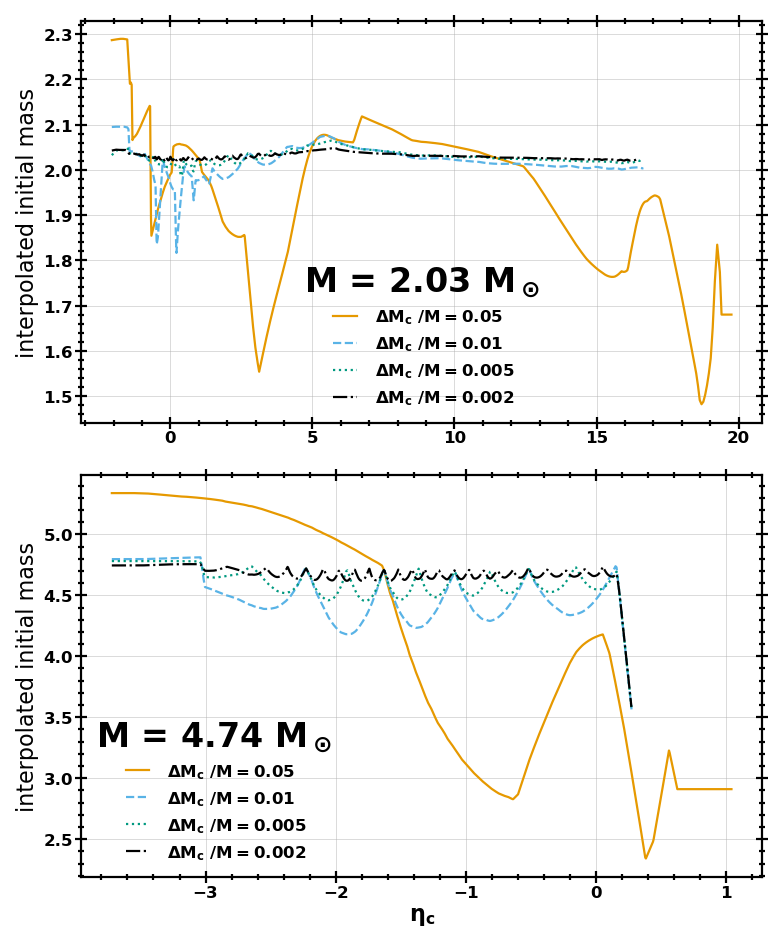

In [22]:
# REMAPPING NUMERICAL DIFFUSION

df = tester.load_table(evol_phase='GB')
fig,ax=plt.subplots(2,1,figsize=(10,12))

varX, varY = tester.scalar_input_columns[1:]

for i, M in enumerate([2.03,4.74]):
    Mi = M
    track = df[(df['MASS']==M)&(df['INITIAL_MASS']==Mi)]

    for j, delta_Mc_div_M in enumerate([0.05,0.01,0.005,0.002]):
        tester.delta_Mc_div_M = delta_Mc_div_M
        tester.integrate_evol_phase(
            df=df,
            evol_phase=tester.evol_phase,
            state_vector={
                'MASS': M,
                varX: track[varX].min(),
                varY: track[varY].min(),
            },
            delta_t=track["AGE"].max()
            / tester.num_integration_steps,
        )

        df_MESA = track
        df_MINT = tester.df_evol_dict[tester.evol_phase]
        ax[i].plot(df_MINT['CENTRAL_DEGENERACY'],df_MINT['INITIAL_MASS'],label='$\Delta M_\mathrm{c}~/M = $'+f'{delta_Mc_div_M}')

    # ax[i].axhline(M,c='black')
    ax[i].legend(title = f'M = {M}'+'$~\mathrm{M}_\odot$')
    ax[i].set(ylabel='interpolated initial mass')
ax[1].set(xlabel=r'$\eta_\mathrm{c}$')
fig.tight_layout()
plt.savefig('plots/remapping_numerical_diffusion.jpeg',dpi=200)
# plt.close()

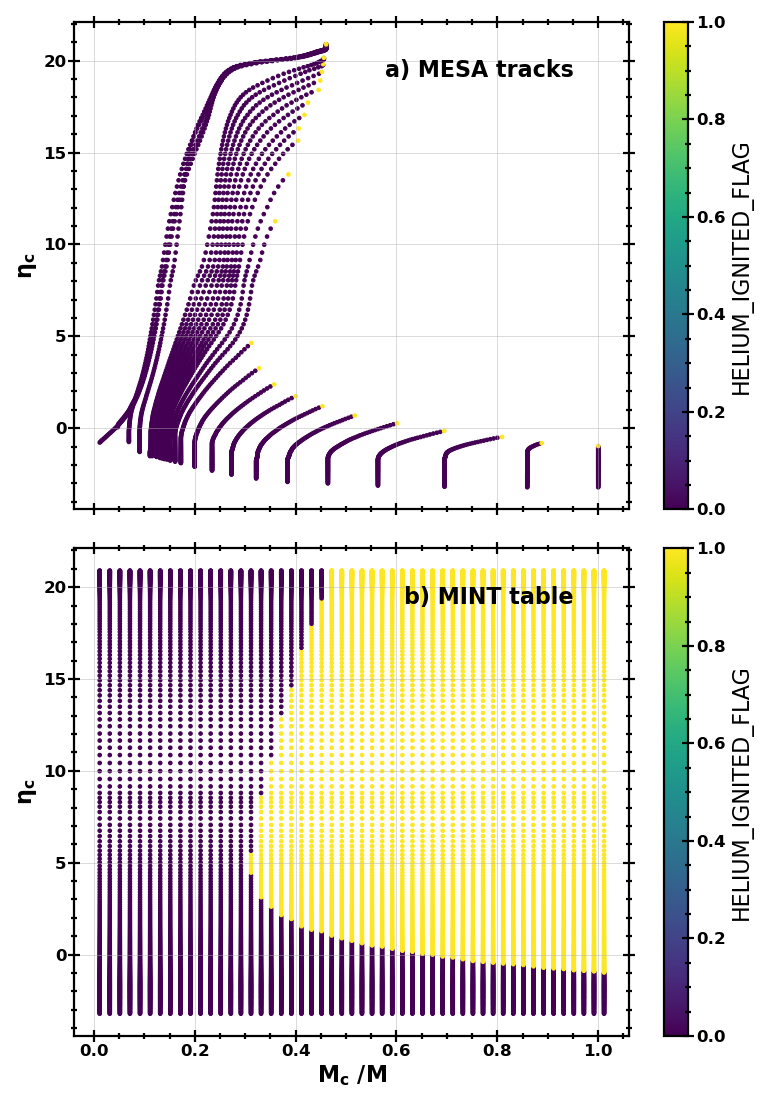

In [20]:

df_GB = tester.load_table(evol_phase="GB")
df_GB['HELIUM_CORE_MASS'] = df_GB['MASS']*df_GB['HELIUM_CORE_MASS_FRACTION']
df_mass = df_GB[(df_GB['MASS']==1.03)&(df_GB['HELIUM_CORE_MASS_FRACTION']<=1.0)][[
    'HELIUM_CORE_MASS_FRACTION',
    'HELIUM_CORE_MASS',
    'CENTRAL_DEGENERACY',
    'LOG_EFFECTIVE_TEMPERATURE',
    'MASS',
    'INITIAL_MASS',
    'HELIUM_IGNITION_PARAMETER',
    'HELIUM_IGNITED_FLAG',
    'LOG_LUMINOSITY',
    'HELIUM_LUMINOSITY',
    "AGE_FRACTION",
    ]]
track = df_mass[df_mass['INITIAL_MASS']==1.03]

varY='HELIUM_CORE_MASS_FRACTION'
varX='CENTRAL_DEGENERACY'

tester.delta_Mc_div_M = 0.02
df_remapped = tester.remap_data_to_orthogonal_grid(
            df=df_mass, varX=varX, varY=varY
        )

df_remapped = tester.add_helium_ignition_boundary(
    df = df_remapped
    )

fig,ax=plt.subplots(2,1,figsize = (10,14),sharex=True)
quantity = 'HELIUM_IGNITED_FLAG' #'HELIUM_IGNITION_PARAMETER'
sc1= ax[0].scatter(df_mass['HELIUM_CORE_MASS_FRACTION'],df_mass['CENTRAL_DEGENERACY'],c=df_mass[quantity],s=10)
sc2 = ax[1].scatter(df_remapped['HELIUM_CORE_MASS_FRACTION'],df_remapped['CENTRAL_DEGENERACY'],c=df_remapped[quantity],s=10)
# ax[1].plot(track['HELIUM_CORE_MASS_FRACTION'],track['CENTRAL_DEGENERACY'],alpha=0.1,c='black',ls='--')
cbar = plt.colorbar(sc1,ax=ax[0],location='right',label=quantity)
cbar = plt.colorbar(sc2,ax=ax[1],location='right',label=quantity)

ax[1].set(xlabel='$M_\mathrm{c}~/M$')
ax[0].set(ylabel=r'$\eta_\mathrm{c}$')
ax[1].set(ylabel=r'$\eta_\mathrm{c}$')

# ax[0].legend(title='a) MESA tracks',loc='best',frameon=True,fontsize=10)
# ax[1].legend(title='b) MINT table',loc='best')
ax[0].text(0.9, 0.9, 'a) MESA tracks', horizontalalignment='right', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.9, 0.9, 'b) MINT table', horizontalalignment='right', verticalalignment='center', transform=ax[1].transAxes)

fig.tight_layout()
plt.savefig('plots/helium_ignition.jpeg',dpi=200)

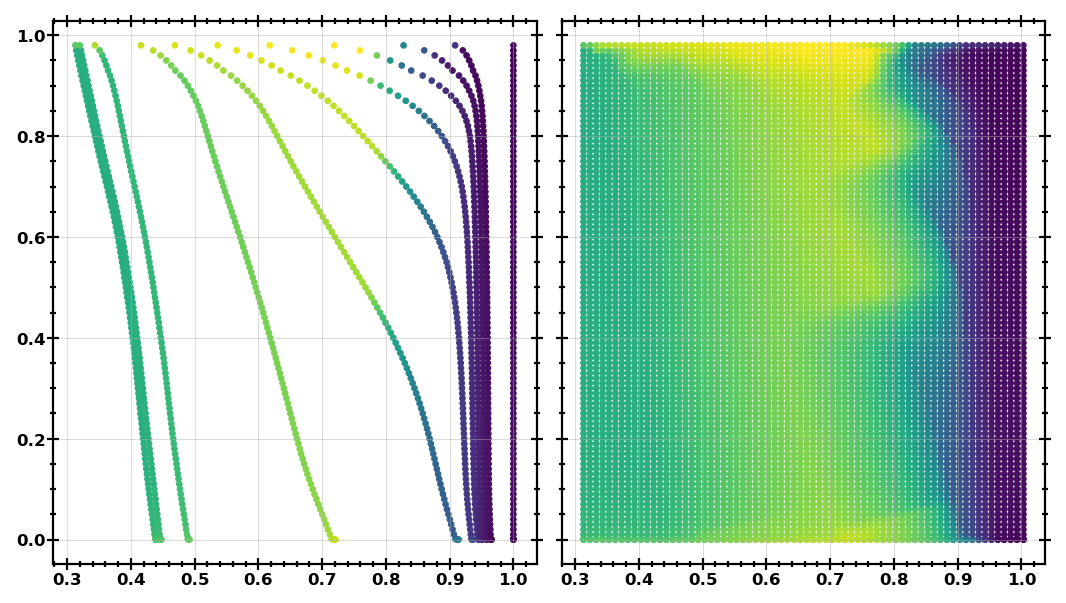

In [4]:
df_CHeB = pd.read_csv('/Users/natalierees/MINT_grids_23051/Z0.02/CHeB/tracks_Z2.00e-02_CHeB.csv',index_col=[0])
df_CHeB = add_Teff(df_CHeB)
df_CHeB = df_CHeB[['MASS','CENTRAL_HELIUM','HELIUM_CORE_MASS_FRACTION','INITIAL_MASS','LUMINOSITY','RADIUS','EFFECTIVE_TEMPERATURE','FIRST_DERIVATIVE_CENTRAL_HELIUM']]
df_CHeB.reset_index(inplace=True)

df_he_flash, df_no_he_flash = tester.split_tracks_post_he_ignition(df=df_CHeB)
tester.num_Mc_vals = 100

mass = 1.03
df_choice = df_no_he_flash

df_sec = df_choice[df_choice['MASS']==mass]
df_remapped = tester.remap_data_to_orthogonal_grid(df=df_sec,varX ='CENTRAL_HELIUM',varY='HELIUM_CORE_MASS_FRACTION')

fig,ax=plt.subplots(1,2,sharey=True,sharex=True)
ax[0].scatter(df_sec['HELIUM_CORE_MASS_FRACTION'],df_sec['CENTRAL_HELIUM'],c=np.log10(df_sec['RADIUS']))
ax[1].scatter(df_remapped['HELIUM_CORE_MASS_FRACTION'],df_remapped['CENTRAL_HELIUM'],c=np.log10(df_remapped['RADIUS']))
